In [9]:
import torch
import torch.nn as nn

class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        # Define RBF centers and gamma
        self.centers = nn.Parameter(torch.empty(degree + 1, input_dim))
        nn.init.uniform_(self.centers, -1, 1)
        self.gamma = nn.Parameter(torch.ones(1) * 0.5)

        # RBF coefficients
        self.rbf_coeffs = nn.Parameter(torch.empty(degree + 1, input_dim, output_dim))
        nn.init.normal_(self.rbf_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))

    def rbf(self, x, centers, gamma):
        # Compute the radial basis function (Gaussian RBF)
        diff = x.unsqueeze(2) - centers.T.unsqueeze(0)
        return torch.exp(-gamma * (diff ** 2).sum(dim=1))

    def forward(self, x):
        # Normalize x to [-1, 1] using tanh
        x = torch.tanh(x)
        # View and repeat input degree + 1 times
        x = x.view((-1, self.inputdim))  # shape = (batch_size, inputdim)
        #### Clip the value ####
        eps = 1e-7
        x = torch.clip(x, min=-1+eps, max=1-eps)

        # Apply RBF transformation
        rbf_x = self.rbf(x, self.centers, self.gamma)  # shape = (batch_size, degree + 1)

        # Compute the RBF interpolation
        y = torch.einsum("bd,dio->bo", rbf_x, self.rbf_coeffs)  # shape = (batch_size, outdim)
        y = y.view(-1, self.outdim)

        return y

class ChebyKAN(nn.Module):
    def __init__(self, layers, degree):
        super(ChebyKAN, self).__init__()
        self.cheb_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.cheb_layers.append(
                ChebyKANLayer(
                    layers[i],
                    layers[i+1],
                    degree,
                )
            )

    def forward(self, inputs):
        out = inputs
        for linear in self.cheb_layers:
            out = linear(out)
        return out

# Example usage
layers = [2, 4, 3, 1]  # Example layer dimensions
degree = 3
model = ChebyKAN(layers, degree)
x = torch.randn(5, layers[0])  # Example input
output = model.forward(x)
print(output)


tensor([[0.3956],
        [0.3954],
        [0.3958],
        [0.3958],
        [0.3957]], grad_fn=<ViewBackward0>)


In [10]:
import torch
import torch.nn as nn

class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        # Define RBF centers and gamma
        self.centers = nn.Parameter(torch.empty(degree + 1, input_dim))
        nn.init.uniform_(self.centers, -1, 1)
        self.gamma = nn.Parameter(torch.ones(1) * 0.5)

        # RBF coefficients
        self.rbf_coeffs = nn.Parameter(torch.empty(degree + 1, input_dim, output_dim))
        nn.init.normal_(self.rbf_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))

    def rbf(self, x, centers, gamma):
        # Compute the radial basis function (Gaussian RBF)
        diff = x.unsqueeze(2) - centers.T.unsqueeze(0)
        return torch.exp(-gamma * (diff ** 2).sum(dim=1))

    def forward(self, x):
        # Normalize x to [-1, 1] using tanh
        x = torch.tanh(x)
        # View and repeat input degree + 1 times
        x = x.view((-1, self.inputdim))  # shape = (batch_size, inputdim)
        #### Clip the value ####
        eps = 1e-7
        x = torch.clip(x, min=-1+eps, max=1-eps)

        # Apply RBF transformation
        rbf_x = self.rbf(x, self.centers, self.gamma)  # shape = (batch_size, degree + 1)

        # Compute the RBF interpolation
        y = torch.einsum("bd,dio->bo", rbf_x, self.rbf_coeffs)  # shape = (batch_size, outdim)
        y = y.view(-1, self.outdim)

        return y

class ChebyKAN(nn.Module):
    def __init__(self, layers, degree):
        super(ChebyKAN, self).__init__()
        self.cheb_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.cheb_layers.append(
                ChebyKANLayer(
                    layers[i],
                    layers[i+1],
                    degree,
                )
            )

    def forward(self, inputs):
        out = inputs
        for linear in self.cheb_layers:
            out = linear(out)
        return out




class MLP(nn.Module):

    def __init__(self, layers, activation):
        super(MLP, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.linears.append(
                nn.Linear(
                    layers[i],
                    layers[i+1],
                )
            )
        self.activation = activation

    def forward(self, inputs):
        out = inputs
        for i in range(len(self.linears)-1):
            out = self.linears[i](out)
            out = self.activation(out)
        return self.linears[-1](out)

In [11]:
def count_model_params(model):

    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Using device: cuda

Our model has 463 parameters.
1000 0.1824384331703186
2000 0.1495835781097412
3000 0.12159400433301926
4000 0.1194949522614479
5000 0.11906757205724716
6000 0.11875521391630173
7000 0.11864808201789856
8000 0.11881862580776215
9000 0.1184580847620964
10000 0.11841225624084473
11000 0.11837337911128998
12000 0.11839877814054489
13000 0.11832313239574432
14000 0.1183539554476738
15000 0.05976073816418648
16000 0.05425967276096344
17000 0.05308203771710396
18000 0.052157141268253326
19000 0.051642585545778275
20000 0.05132070928812027
21000 0.050945546478033066
22000 0.051179900765419006
23000 0.0505528524518013
24000 0.050406478345394135
25000 0.05028528347611427
26000 0.05015771463513374
27000 0.050060681998729706
28000 0.049984727054834366
29000 0.04992172494530678
30000 0.04987597465515137
31000 0.04984290897846222
32000 0.04990115016698837
33000 0.04979141429066658
34000 0.04974894970655441
35000 0.04972486570477486
36000 0.049720801413059235
37000 0.0501031950116

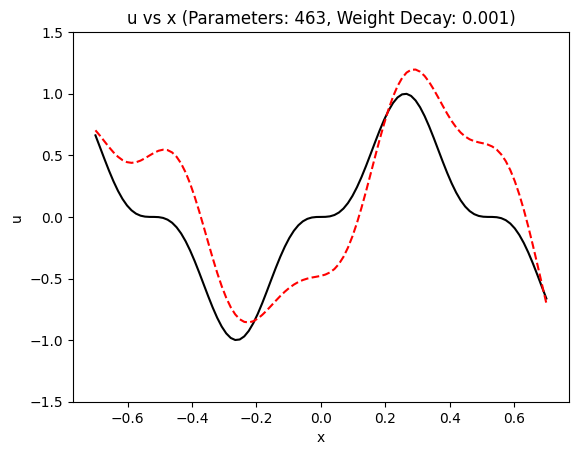

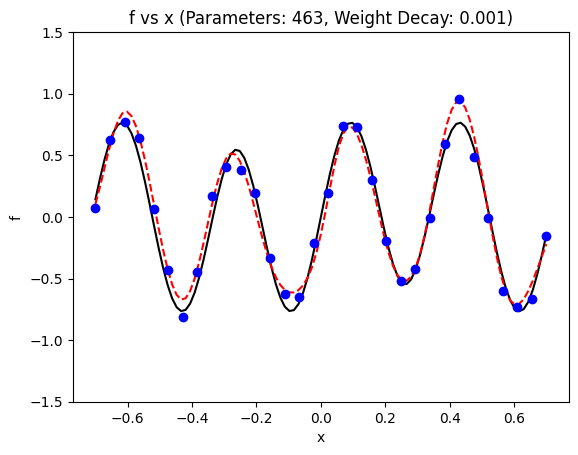

Main


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

import torch
import torch.nn as nn

# Set seed for reproducibility
seed = 9873
torch.manual_seed(seed)
np.random.seed(seed)

# Select device (CUDA for GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load data
data = sio.loadmat("/content/train.mat")
x_test, u_test, f_test = data["x_test"], data["u_test"], data["f_test"]
x_u_train, u_train = data["x_u_train"], data["u_train"]
x_f_train, f_train = data["x_f_train"], data["f_train"]

# Convert data to PyTorch tensors and move to device
x_f_train = torch.tensor(
    data["x_f_train"],
    dtype=torch.float32,
    requires_grad=True,
).to(device)
f_train = torch.tensor(
    data["f_train"], dtype=torch.float32,
).to(device)
x_u_train = torch.tensor(
    data["x_u_train"], dtype=torch.float32,
).to(device)
u_train = torch.tensor(
    data["u_train"], dtype=torch.float32,
).to(device)

# Define loss function
def loss_function():
    D = 0.01
    k = 0.7
    # Boundary condition
    u_pred = model(x_u_train)
    loss_u = torch.mean(
        (u_pred - u_train) ** 2
    )
    # Equation
    u_pred = model(x_f_train)
    u_x = torch.autograd.grad(
        u_pred, x_f_train, grad_outputs=torch.ones_like(u_pred), create_graph=True,
    )[0]
    u_xx = torch.autograd.grad(
        u_x, x_f_train, grad_outputs=torch.ones_like(u_x), create_graph=True,
    )[0]
    loss_f = torch.mean(
        (D * u_xx + k * torch.tanh(u_pred) - f_train) ** 2
    )
    return loss_u + loss_f

# Define model
model = ChebyKAN(
    layers=[1, 5, 5, 1], degree=9,
).to(device)

# Define optimizer and scheduler
weight_decay = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[40000],
    gamma=0.1,
)

# Function to count model parameters
def count_model_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print number of parameters
n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')

# Training function
def train():
    niter = 50000
    min_loss = 1000

    for i in range(niter):
        def closure():
            optimizer.zero_grad()
            loss = loss_function()
            loss.backward()
            return loss

        optimizer.step(closure)

        if (i+1) % 1000 == 0:
            current_loss = loss_function().item()
            print(i+1, current_loss, flush=True)

# Train the model
train()

# Model prediction
x_pred = torch.tensor(x_test, dtype=torch.float32, requires_grad=True).to(device)
u_pred = model(x_pred)
u_x = torch.autograd.grad(
    u_pred, x_pred, grad_outputs=torch.ones_like(u_pred), create_graph=True,
)[0]
u_xx = torch.autograd.grad(
    u_x, x_pred, grad_outputs=torch.ones_like(u_x), create_graph=True,
)[0]
D = 0.01
k = 0.7
f_pred = D * u_xx + k * torch.tanh(u_pred)
u_pred = u_pred.detach().cpu().numpy()
f_pred = f_pred.detach().cpu().numpy()

# Plotting
plt.plot(x_test, u_test, "k-")
plt.plot(x_test, u_pred, "r--")
plt.xlabel("x")
plt.ylabel("u")
plt.ylim([-1.5, 1.5])
plt.title(f'u vs x (Parameters: {n_params}, Weight Decay: {weight_decay})')
plt.show()

plt.figure()
plt.plot(x_test, f_test, "k-")
plt.plot(x_test, f_pred, "r--")
plt.plot(x_f_train.detach().cpu().numpy(), f_train.cpu().numpy(), "bo")
plt.xlabel("x")
plt.ylabel("f")
plt.ylim([-1.5, 1.5])
plt.title(f'f vs x (Parameters: {n_params}, Weight Decay: {weight_decay})')
plt.show()

print("Main")



In [17]:
def count_model_params(model):

    return sum(p.numel() for p in model.parameters() if p.requires_grad)



Using device: cuda

Our model has 481 parameters.
1000 4.0216052532196045 0.27695342898368835
2000 4.122468709945679 0.17644120752811432
3000 4.2060160636901855 0.054527200758457184
4000 3.8576157093048096 0.008118635974824429
5000 3.9900152683258057 0.0014225725317373872
6000 4.160284042358398 0.0012614959850907326
7000 3.834568738937378 0.0012110682437196374
8000 4.020757675170898 0.0011863249819725752
9000 4.2225635051727295 0.0011707525700330734
10000 3.8814313411712646 0.001159873092547059
11000 3.9483156204223633 0.0011543601285666227
12000 4.308670997619629 0.0011475429637357593
13000 3.851895332336426 0.001146591966971755
14000 3.8701746463775635 0.001210001646541059
15000 4.373631238937378 0.0011912751942873001
16000 3.8937175273895264 0.0011348812840878963
17000 3.851386547088623 0.0011322174686938524
18000 4.336552619934082 0.0012228174600750208
19000 3.83681058883667 0.0011282606283202767
20000 3.889218330383301 0.00112654990516603
21000 4.315806150436401 0.0011306108208373

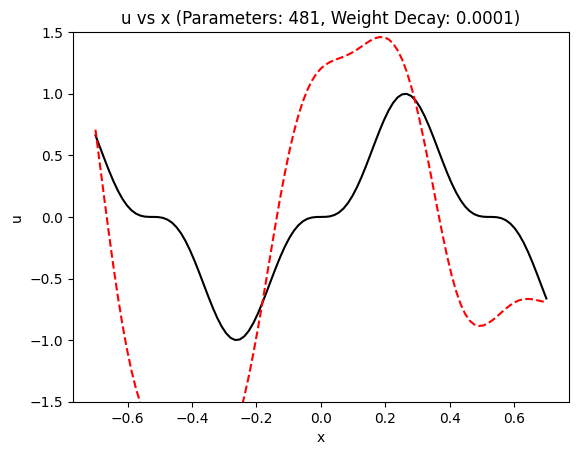

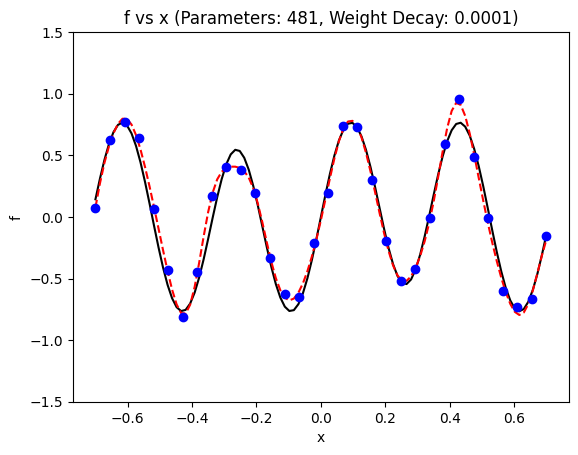

End main


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import time
import torch
import torch.nn as nn


device = torch.device("cuda")
print("Using device:", device)

data = sio.loadmat("/content/train.mat")
x_test, u_test, f_test = data["x_test"], data["u_test"], data["f_test"]
x_u_train, u_train = data["x_u_train"], data["u_train"]
x_f_train, f_train = data["x_f_train"], data["f_train"]

x_f_train = torch.tensor(
    data["x_f_train"],
    dtype=torch.float32,
    requires_grad=True,
).to(device)
f_train = torch.tensor(
    data["f_train"], dtype=torch.float32,
).to(device)
x_u_train = torch.tensor(
    data["x_u_train"], dtype=torch.float32,
).to(device)
u_train = torch.tensor(
    data["u_train"], dtype=torch.float32,
).to(device)


def loss_function():
    D = 0.01
    k = 0.7
    # boundary condition
    u_pred = model(x_u_train)
    loss_u = torch.mean(
        (u_pred - u_train) ** 2
    )
    # equation
    u_pred = model(x_f_train)
    u_x = torch.autograd.grad(
        u_pred, x_f_train, grad_outputs=torch.ones_like(u_pred), create_graph=True,
    )[0]
    u_xx = torch.autograd.grad(
        u_x, x_f_train, grad_outputs=torch.ones_like(u_x), create_graph=True,
    )[0]
    loss_f = torch.mean(
        (D * u_xx + k * torch.tanh(u_pred) - f_train) ** 2
    )
    return loss_u + loss_f


class MLP(nn.Module):
    def __init__(self, layers, activation):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = activation

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x


def count_model_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


model = MLP(
    layers=[1, 20, 20, 1],
    activation=torch.tanh,
).to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
weight_decay = 1e-4
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[40000],
    gamma=0.1,
)


def train():
    niter = 50000
    t0 = time.time()

    for i in range(niter):
        def closure():
            optimizer.zero_grad()
            loss = loss_function()
            loss.backward()
            return loss

        optimizer.step(closure)
        scheduler.step()

        if (i+1) % 1000 == 0:
            current_loss = loss_function().item()
            t1 = time.time()
            print(i+1, t1 - t0, current_loss, flush=True)
            t0 = time.time()


train()


x_pred = torch.tensor(x_test, dtype=torch.float32, requires_grad=True).to(device)
u_pred = model(x_pred)
u_x = torch.autograd.grad(
    u_pred, x_pred, grad_outputs=torch.ones_like(u_pred), create_graph=True,
)[0]
u_xx = torch.autograd.grad(
    u_x, x_pred, grad_outputs=torch.ones_like(u_x), create_graph=True,
)[0]
D = 0.01
k = 0.7
f_pred = D * u_xx + k * torch.tanh(u_pred)
u_pred = u_pred.detach().cpu().numpy()
f_pred = f_pred.detach().cpu().numpy()


plt.plot(x_test, u_test, "k-")
plt.plot(x_test, u_pred, "r--")
plt.xlabel("x")
plt.ylabel("u")
plt.ylim([-1.5, 1.5])
plt.title(f'u vs x (Parameters: {n_params}, Weight Decay: {weight_decay})')
plt.show()

plt.figure()
plt.plot(x_test, f_test, "k-")
plt.plot(x_test, f_pred, "r--")
plt.plot(x_f_train.detach().cpu().numpy(), f_train.cpu().numpy(), "bo")
plt.xlabel("x")
plt.ylabel("f")
plt.ylim([-1.5, 1.5])
plt.title(f'f vs x (Parameters: {n_params}, Weight Decay: {weight_decay})')
plt.show()


print("End main")
